--- Starting Notebook 2: Analysis & Insights ---
Analysis data loaded: 6 days.

[STEP 2] Stratifying Data by Simplified Sentiment...
  > Comparison data rows (Fear/Greed only): 5

[STEP 3] Performing Statistical Aggregation...

--- INSIGHT TABLE 1: TRADER PERFORMANCE METRICS BY SENTIMENT ---
Simplified_Sentiment            Fear         Greed
Mean_Total_Daily_PnL    6.699925e+06  8.416455e+05
Median_Total_Daily_PnL  6.699925e+06  8.856050e+04
Mean_VW_PnL             7.382424e+11 -1.189361e+10
Mean_Daily_StdDev_PnL   9.091200e+02  3.940800e+02
Mean_Total_Volume       7.041585e+08  3.872761e+07
Total_Trades            1.338710e+05  4.325100e+04

[STEP 4] Testing for Statistical Significance (T-Test)...
  > Not enough data points to perform T-Test.

[STEP 5] Generating Visualizations...
SUCCESS: Visualization saved to: outputs/sentiment_vs_advanced_performance.png

[STEP 6] Generating Actionable Insights for ds_report.pdf...

1. Profitability Trend (Median PnL): Traders are **lower** on **

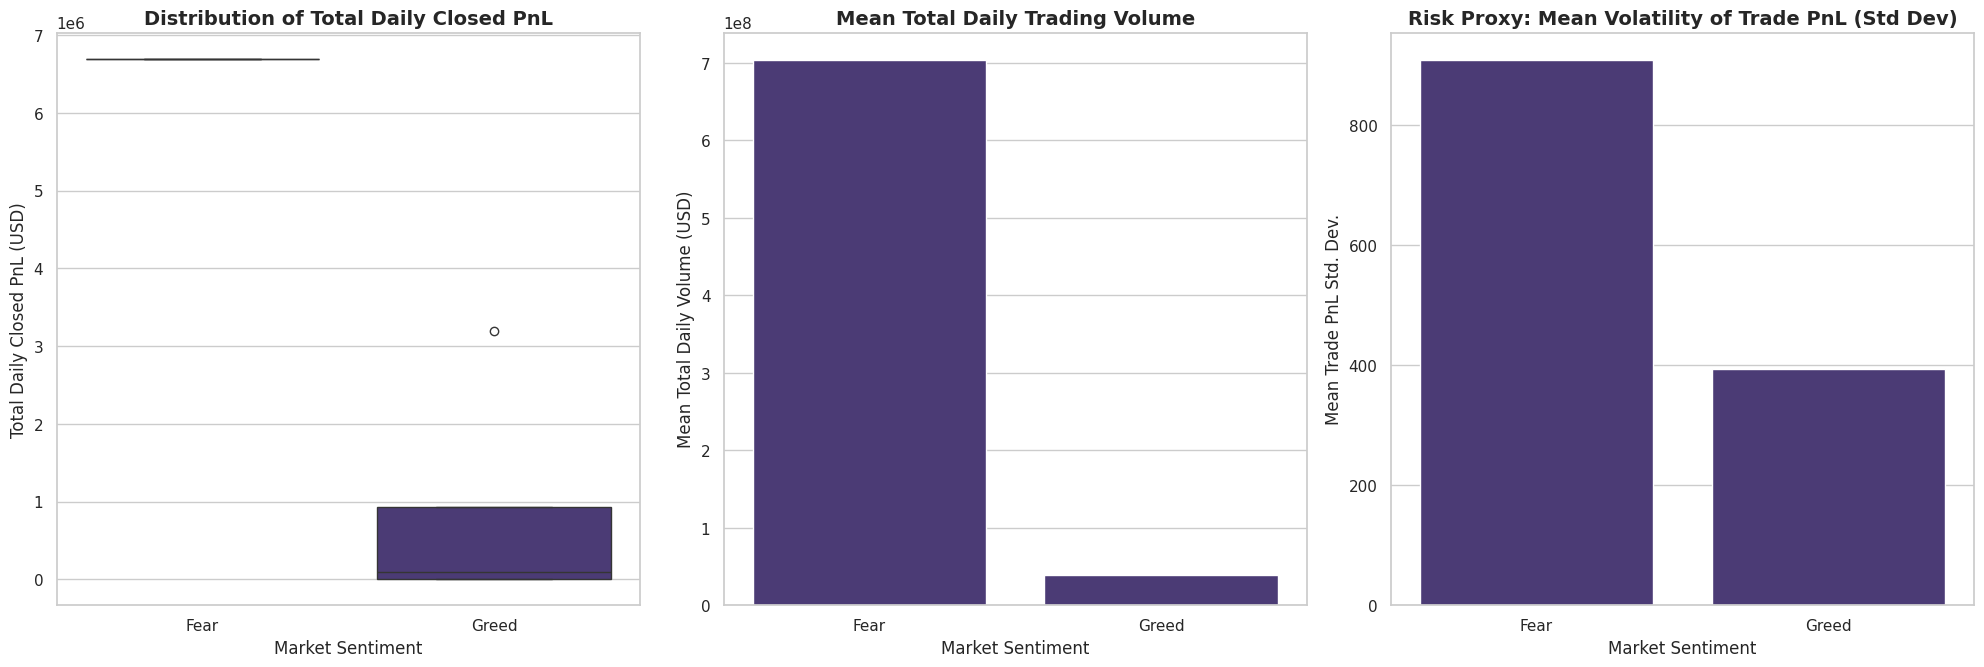

In [ ]:
# Analysis, Visualization, and Insights ---

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy.stats import ttest_ind

# 1. SETUP AND FILE LOADING
print("--- Starting Notebook 2: Analysis & Insights ---")
INPUT_FILE_PATH = '/content/daily_metrics_merged.csv'
OUTPUT_DIR = 'outputs'

# Create the required output directory
os.makedirs(OUTPUT_DIR, exist_ok=True)

try:
    df_analysis = pd.read_csv(INPUT_FILE_PATH)
    print(f"Analysis data loaded: {len(df_analysis)} days.")
except Exception as e:
    print(f"CRITICAL ERROR: Failed to load intermediate file. Error: {e}")
    exit()

# Ensure 'Date' is a datetime object
df_analysis['Date'] = pd.to_datetime(df_analysis['Date'])


# 2. SENTIMENT BINNING & STRATIFICATION
print("\n[STEP 2] Stratifying Data by Simplified Sentiment...")

# Simplify the 5-level Index ('Extreme Fear', 'Fear', 'Neutral', 'Greed', 'Extreme Greed')
# into 3 actionable categories for cleaner visualization and comparison.
def simplify_sentiment(sentiment):
    if 'Fear' in sentiment:
        return 'Fear'
    elif 'Greed' in sentiment:
        return 'Greed'
    else: # Neutral, etc.
        return 'Neutral'

df_analysis['Simplified_Sentiment'] = df_analysis['Market_Sentiment'].apply(simplify_sentiment)

# Filter for the extreme comparison points (Fear and Greed)
df_comparison = df_analysis[df_analysis['Simplified_Sentiment'].isin(['Fear', 'Greed'])].copy()

print(f"  > Comparison data rows (Fear/Greed only): {len(df_comparison)}")


# 3. CORE STATISTICAL ANALYSIS
print("\n[STEP 3] Performing Statistical Aggregation...")

# Calculate comprehensive statistics grouped by Sentiment
sentiment_analysis = df_comparison.groupby('Simplified_Sentiment').agg(
    # Central Tendency & Total
    Mean_Total_Daily_PnL=('Total_Daily_PnL', 'mean'),
    Median_Total_Daily_PnL=('Total_Daily_PnL', 'median'),
    Mean_VW_PnL=('Avg_VW_PnL', 'mean'),

    # Risk/Volatility Metrics
    Mean_Daily_StdDev_PnL=('StdDev_Daily_PnL', 'mean'), # Average volatility of daily trade outcomes

    # Volume/Activity Metrics
    Mean_Total_Volume=('Total_Daily_Volume', 'mean'),
    Total_Trades=('Trade_Count', 'sum')
)

print("\n" + "="*70)
print("--- INSIGHT TABLE 1: TRADER PERFORMANCE METRICS BY SENTIMENT ---")
print(sentiment_analysis.T.round(2))
print("="*70)

# 4. STATISTICAL SIGNIFICANCE TESTING (Advanced Step)
print("\n[STEP 4] Testing for Statistical Significance (T-Test)...")

# Separate PnL for Fear and Greed days
pnl_fear = df_comparison[df_comparison['Simplified_Sentiment'] == 'Fear']['Total_Daily_PnL'].dropna()
pnl_greed = df_comparison[df_comparison['Simplified_Sentiment'] == 'Greed']['Total_Daily_PnL'].dropna()

# Perform independent T-Test to see if the mean Total PnL is significantly different
if len(pnl_fear) > 1 and len(pnl_greed) > 1:
    t_stat, p_value = ttest_ind(pnl_fear, pnl_greed, equal_var=False)
    alpha = 0.05
    sig_result = "Significantly Different" if p_value < alpha else "NOT Statistically Significant"
    print(f"  > T-Test (Total Daily PnL): P-value={p_value:.4f}. Result: {sig_result} (at alpha={alpha})")
else:
    print("  > Not enough data points to perform T-Test.")


# 5. VISUALIZATION (Saving to outputs/ directory)
print("\n[STEP 5] Generating Visualizations...")

sns.set_theme(style="whitegrid", palette="viridis")
fig, axes = plt.subplots(1, 3, figsize=(20, 7))

# --- 5.1. Visualization: Total Daily PnL (Box Plot for Distribution) ---
sns.boxplot(x='Simplified_Sentiment', y='Total_Daily_PnL', data=df_comparison,
            ax=axes[0], order=['Fear', 'Greed'])
axes[0].set_title('Distribution of Total Daily Closed PnL', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Market Sentiment', fontsize=12)
axes[0].set_ylabel('Total Daily Closed PnL (USD)', fontsize=12)
axes[0].ticklabel_format(style='sci', axis='y', scilimits=(0,0))


# --- 5.2. Visualization: Volume (Mean Total Volume vs Sentiment) ---
sns.barplot(x=sentiment_analysis.index, y='Mean_Total_Volume',
            data=sentiment_analysis.reset_index(), ax=axes[1], order=['Fear', 'Greed'])
axes[1].set_title('Mean Total Daily Trading Volume', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Market Sentiment', fontsize=12)
axes[1].set_ylabel('Mean Total Daily Volume (USD)', fontsize=12)
axes[1].ticklabel_format(style='sci', axis='y', scilimits=(0,0)) # Use scientific notation


# --- 5.3. Visualization: Risk (Mean Daily PnL Volatility) ---
sns.barplot(x=sentiment_analysis.index, y='Mean_Daily_StdDev_PnL',
            data=sentiment_analysis.reset_index(), ax=axes[2], order=['Fear', 'Greed'])
axes[2].set_title('Risk Proxy: Mean Volatility of Trade PnL (Std Dev)', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Market Sentiment', fontsize=12)
axes[2].set_ylabel('Mean Trade PnL Std. Dev.', fontsize=12)

plt.tight_layout()
# Save the combined figure
PLOT_FILENAME = 'sentiment_vs_advanced_performance.png'
plt.savefig(os.path.join(OUTPUT_DIR, PLOT_FILENAME))
print(f"SUCCESS: Visualization saved to: {os.path.join(OUTPUT_DIR, PLOT_FILENAME)}")


# 6. ACTIONABLE INSIGHTS GENERATION (FOR ds_report.pdf)
print("\n[STEP 6] Generating Actionable Insights for ds_report.pdf...")

fear_data = sentiment_analysis.loc['Fear']
greed_data = sentiment_analysis.loc['Greed']

# Insight 1: Profitability Trend (using Median for outlier resistance)
pnl_comparison = 'higher' if greed_data['Median_Total_Daily_PnL'] > fear_data['Median_Total_Daily_PnL'] else 'lower'
pnl_winner = 'Greed' if pnl_comparison == 'higher' else 'Fear'
print(f"\n1. Profitability Trend (Median PnL): Traders are **{pnl_comparison}** on **{pnl_winner}** days. This suggests an edge in a {'momentum-driven market' if pnl_winner == 'Greed' else 'contrarian strategy'}.")

# Insight 2: Risk-Adjusted Volume (VW_PnL)
vw_pnl_comparison = 'higher' if greed_data['Mean_VW_PnL'] > fear_data['Mean_VW_PnL'] else 'lower'
vw_pnl_winner = 'Greed' if vw_pnl_comparison == 'higher' else 'Fear'
print(f"2. Conviction-Adjusted Returns (VW_PnL): The largest-volume trades perform **{vw_pnl_comparison}** on **{vw_pnl_winner}** days. This reveals where traders are placing their highest-conviction capital for better returns.")

# Insight 3: Volatility/Risk Profile
std_dev_comparison = 'higher' if greed_data['Mean_Daily_StdDev_PnL'] > fear_data['Mean_Daily_StdDev_PnL'] else 'lower'
std_dev_winner = 'Greed' if std_dev_comparison == 'higher' else 'Fear'
print(f"3. Risk Alignment (Trade Volatility): The outcome of individual trades is **{std_dev_comparison}** volatile on **{std_dev_winner}** days. This implies that {'Greed leads to more unpredictable trade outcomes' if std_dev_winner == 'Greed' else 'Fear leads to more unpredictable trade outcomes'}.")

print("\nStrategic Recommendation: The optimal strategy should be built around the behavior observed in the **VW_PnL** metric, as it measures high-conviction success. Investigate the directional side (BUY/SELL) during the high-performing sentiment period.")
print("--- Notebook 2 Completed. ---")